✅ PyTorch version: 2.9.0+cu126
✅ CUDA available: True

📊 Loading MNLI dataset...
Attempting Method 1: Loading via GLUE benchmark...
✅ Successfully loaded MNLI via GLUE!

📊 Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

📝 First training example:
{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.', 'hypothesis': 'Product and geography are what make cre

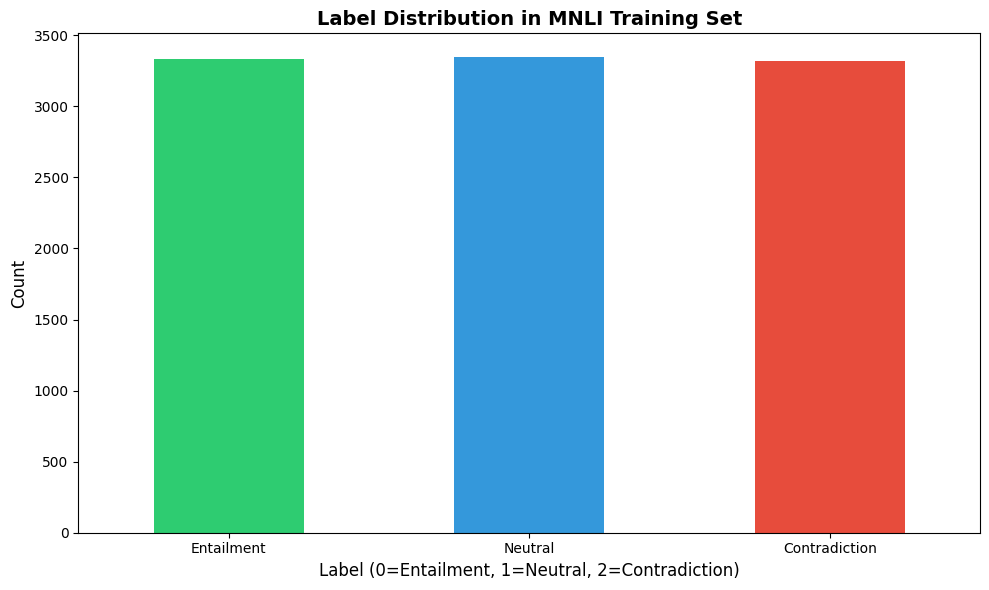

✅ Label distribution saved: mnli_label_distribution.png

Text length statistics:
  Premise length: 19.9 words (avg)
  Hypothesis length: 10.0 words (avg)

🤖 Loading DistilBERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model: distilbert-base-uncased
✅ Parameters: 66,955,779
✅ Task: Natural Language Inference (3 classes)

🔧 Tokenizing premise-hypothesis pairs...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

✅ Tokenization complete!
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

⚙️ Configuring training...
✅ Training configuration ready!

🚀 STARTING TRAINING (Expected: 3-5 minutes)



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.859800,0.846812,0.622000,0.620692
2,0.673900,0.792945,0.659000,0.658057
3,0.408200,0.858402,0.665000,0.665704



✅ TRAINING COMPLETED!

📊 Evaluating model...



🎯 RESULTS:
  Accuracy: 0.6650 (66.50%)
  F1-Score (Macro): 0.6657
  Loss: 0.8584

📈 Generating analysis...

CLASSIFICATION REPORT
               precision    recall  f1-score   support

   Entailment     0.7299    0.6858    0.7072       331
      Neutral     0.6125    0.6890    0.6485       328
Contradiction     0.6625    0.6217    0.6415       341

     accuracy                         0.6650      1000
    macro avg     0.6683    0.6655    0.6657      1000
 weighted avg     0.6684    0.6650    0.6655      1000



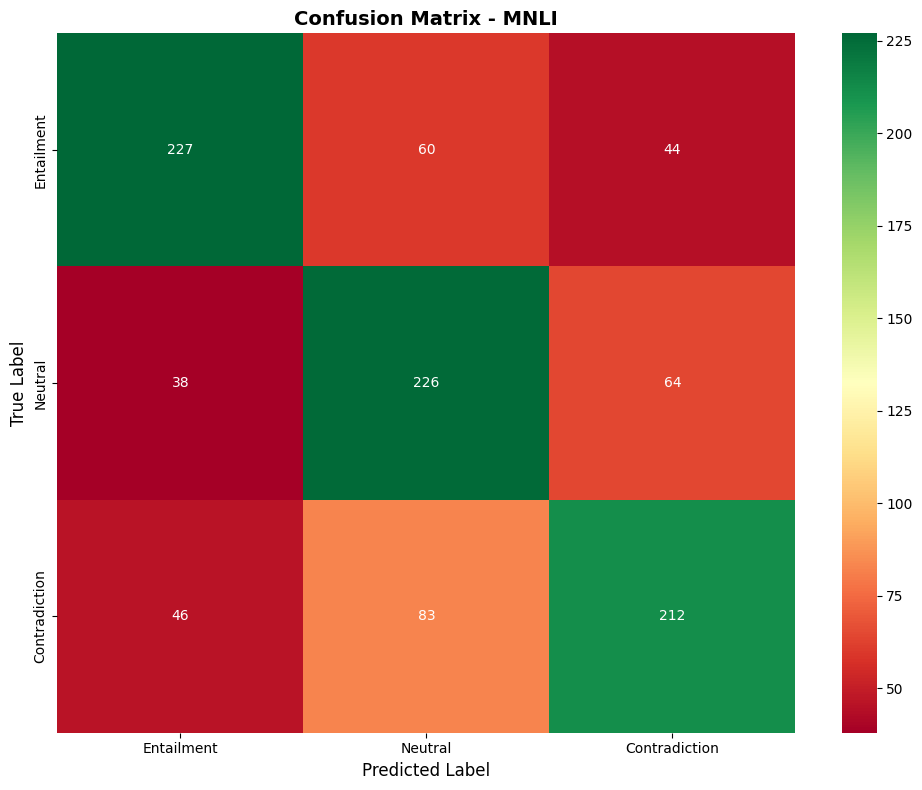

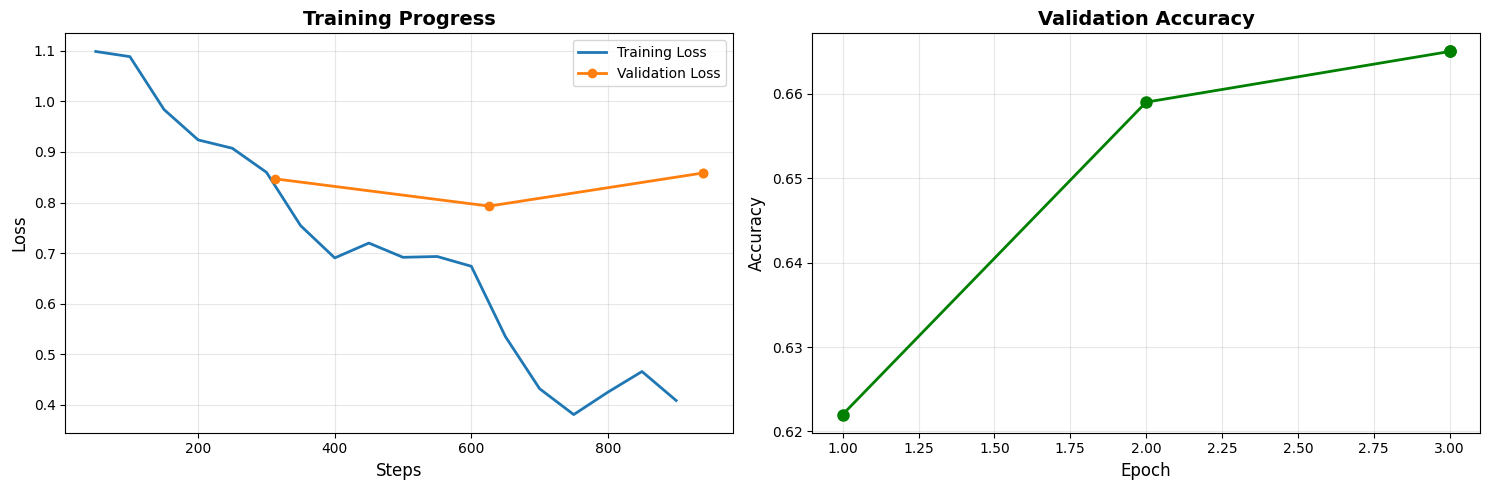


✅ Model saved to: ./fine-tuned-bert-mnli

🔮 TESTING INFERENCE

Premise: A woman plays violin.
Hypothesis: A person performs music.
Expected: Entailment | Predicted: Entailment (75.61%) ✅

Premise: A man reads in library.
Hypothesis: The man sleeps on couch.
Expected: Contradiction | Predicted: Contradiction (54.16%) ✅

Premise: Children play in park.
Hypothesis: The children have fun.
Expected: Neutral | Predicted: Entailment (52.18%) ❌

✅ ALL DONE!
✓ Task: Natural Language Inference
✓ Training samples: 10,000
✓ Accuracy: 66.50%
✓ Files saved: confusion matrix, training curves, model


In [4]:
# ============================================================================
# STEP 1: INSTALL & IMPORT
# ============================================================================
!pip install -q transformers datasets evaluate accelerate scikit-learn matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, DatasetDict, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate
from sklearn.metrics import confusion_matrix, classification_report
import torch
import requests
import json

print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")

# ============================================================================
# STEP 2: LOAD MNLI DATASET (WITH FALLBACK OPTIONS)
# ============================================================================
print("\n📊 Loading MNLI dataset...")

def load_mnli_dataset():
    """
    Try multiple methods to load MNLI dataset:
    1. Direct load_dataset (recommended)
    2. Using specific dataset name variants
    3. Manual download via API (fallback)
    """

    # METHOD 1: Try standard GLUE loading
    try:
        print("Attempting Method 1: Loading via GLUE benchmark...")
        dataset = load_dataset("glue", "mnli")
        print("✅ Successfully loaded MNLI via GLUE!")
        return dataset
    except Exception as e:
        print(f"❌ Method 1 failed: {e}")

    # METHOD 2: Try alternative dataset names
    try:
        print("\nAttempting Method 2: Loading via nyu-mll/glue...")
        dataset = load_dataset("nyu-mll/glue", "mnli")
        print("✅ Successfully loaded MNLI via nyu-mll/glue!")
        return dataset
    except Exception as e:
        print(f"❌ Method 2 failed: {e}")

    # METHOD 3: Try direct MNLI dataset
    try:
        print("\nAttempting Method 3: Loading via multi_nli...")
        dataset = load_dataset("multi_nli")
        print("✅ Successfully loaded MNLI via multi_nli!")
        return dataset
    except Exception as e:
        print(f"❌ Method 3 failed: {e}")

    # METHOD 4: Manual download via API (last resort)
    print("\nAttempting Method 4: Manual download via HuggingFace API...")
    return load_mnli_via_api()

def load_mnli_via_api():
    """
    Load MNLI dataset manually via HuggingFace API.
    This is a fallback method if direct loading fails.
    """
    print("📥 Downloading MNLI data via API...")

    base_url = "https://datasets-server.huggingface.co/rows"

    def fetch_data(split, num_samples):
        """Fetch data from HuggingFace API"""
        all_data = []
        offset = 0
        batch_size = 100

        while len(all_data) < num_samples:
            url = f"{base_url}?dataset=nyu-mll%2Fglue&config=mnli&split={split}&offset={offset}&length={batch_size}"

            try:
                response = requests.get(url, timeout=30)
                response.raise_for_status()
                data = response.json()

                if 'rows' not in data or len(data['rows']) == 0:
                    break

                for row in data['rows']:
                    if len(all_data) >= num_samples:
                        break
                    all_data.append(row['row'])

                offset += batch_size
                print(f"  Downloaded {len(all_data)}/{num_samples} samples from {split}...", end='\r')

            except Exception as e:
                print(f"\n⚠️ Error fetching data: {e}")
                break

        print(f"\n✅ Downloaded {len(all_data)} samples from {split}")
        return all_data

    # Download train and validation data
    train_data = fetch_data("train", 10000)
    val_data = fetch_data("validation_matched", 1000)

    if not train_data or not val_data:
        raise Exception("Failed to download MNLI data via API")

    # Convert to HuggingFace Dataset format
    train_dataset = Dataset.from_list(train_data)
    val_dataset = Dataset.from_list(val_data)

    dataset = DatasetDict({
        'train': train_dataset,
        'validation_matched': val_dataset
    })

    print("✅ Successfully created dataset from API data!")
    return dataset

# Load the dataset using the best available method
try:
    full_dataset = load_mnli_dataset()

    print("\n📊 Dataset loaded successfully!")
    print(full_dataset)
    print("\n📝 First training example:")
    print(full_dataset['train'][0])

except Exception as e:
    print(f"\n❌ All loading methods failed: {e}")
    print("\n💡 Alternative: Download MNLI manually from:")
    print("   https://huggingface.co/datasets/nyu-mll/glue")
    print("   Or use AG News dataset instead (easier to load)")
    raise

# ============================================================================
# STEP 3: CREATE SMALL SUBSET FOR FAST TRAINING
# ============================================================================
print("\n📊 Creating training subset...")

# Take small subset for fast training
small_train = full_dataset['train'].shuffle(seed=42).select(range(10000))

# Handle validation set (might be 'validation_matched' or 'validation')
if 'validation_matched' in full_dataset:
    small_val = full_dataset['validation_matched'].shuffle(seed=42).select(range(1000))
elif 'validation' in full_dataset:
    small_val = full_dataset['validation'].shuffle(seed=42).select(range(1000))
else:
    # Create validation from train if needed
    print("⚠️ No validation set found, splitting from training data...")
    train_test_split = full_dataset['train'].train_test_split(test_size=0.1, seed=42)
    small_train = train_test_split['train'].select(range(10000))
    small_val = train_test_split['test'].select(range(1000))

# Create new dataset
dataset = DatasetDict({
    'train': small_train,
    'validation': small_val
})

print(f"\n✅ Training samples: {len(dataset['train'])}")
print(f"✅ Validation samples: {len(dataset['validation'])}")

# Explore first example
print("\n📝 Example MNLI pair:")
example = dataset['train'][0]
print(f"Premise: {example['premise']}")
print(f"Hypothesis: {example['hypothesis']}")
print(f"Label: {example['label']} (0=entailment, 1=neutral, 2=contradiction)")

# ============================================================================
# STEP 4: DATA EXPLORATION
# ============================================================================
print("\n📊 Dataset Statistics:")

train_df = pd.DataFrame(dataset['train'])
print(f"\nLabel distribution in training set:")
label_counts = train_df['label'].value_counts().sort_index()
labels_names = ['Entailment', 'Neutral', 'Contradiction']

for idx, label in enumerate(labels_names):
    count = label_counts.get(idx, 0)
    print(f"  {idx} ({label}): {count} ({count/len(train_df)*100:.1f}%)")

# Visualize label distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=['#2ecc71', '#3498db', '#e74c3c'])
plt.title('Label Distribution in MNLI Training Set', fontsize=14, fontweight='bold')
plt.xlabel('Label (0=Entailment, 1=Neutral, 2=Contradiction)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1, 2], labels_names, rotation=0)
plt.tight_layout()
plt.savefig('mnli_label_distribution.png', dpi=300)
plt.show()

print("✅ Label distribution saved: mnli_label_distribution.png")

# Show sample lengths
train_df['premise_length'] = train_df['premise'].str.split().str.len()
train_df['hypothesis_length'] = train_df['hypothesis'].str.split().str.len()

print(f"\nText length statistics:")
print(f"  Premise length: {train_df['premise_length'].mean():.1f} words (avg)")
print(f"  Hypothesis length: {train_df['hypothesis_length'].mean():.1f} words (avg)")

# ============================================================================
# STEP 5: LOAD DISTILBERT MODEL
# ============================================================================
print("\n🤖 Loading DistilBERT model...")

model_name = "distilbert-base-uncased"
num_labels = 3

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

print(f"✅ Model: {model_name}")
print(f"✅ Parameters: {model.num_parameters():,}")
print(f"✅ Task: Natural Language Inference (3 classes)")

# ============================================================================
# STEP 6: TOKENIZE PREMISE-HYPOTHESIS PAIRS
# ============================================================================
print("\n🔧 Tokenizing premise-hypothesis pairs...")

def tokenize_function(examples):
    """
    For NLI, we tokenize BOTH premise and hypothesis.
    The tokenizer automatically formats them as: [CLS] premise [SEP] hypothesis [SEP]
    """
    return tokenizer(
        examples["premise"],
        examples["hypothesis"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns
columns_to_remove = [col for col in tokenized_datasets['train'].column_names
                     if col not in ['input_ids', 'attention_mask', 'label']]
tokenized_datasets = tokenized_datasets.remove_columns(columns_to_remove)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

print("✅ Tokenization complete!")
print(tokenized_datasets)

# ============================================================================
# STEP 7: TRAINING SETUP
# ============================================================================
print("\n⚙️ Configuring training...")

# Load metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    """Compute accuracy and F1 for NLI task."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1']
    }

# SPEED-OPTIMIZED TRAINING ARGUMENTS
training_args = TrainingArguments(
    output_dir="./results_mnli",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=5e-5,
    warmup_steps=200,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="none",
    seed=42
)

print("✅ Training configuration ready!")

# ============================================================================
# STEP 8: TRAIN MODEL
# ============================================================================
print("\n" + "="*60)
print("🚀 STARTING TRAINING (Expected: 3-5 minutes)")
print("="*60 + "\n")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

train_result = trainer.train()

print("\n" + "="*60)
print("✅ TRAINING COMPLETED!")
print("="*60 + "\n")

# ============================================================================
# STEP 9: EVALUATE
# ============================================================================
print("📊 Evaluating model...")
eval_results = trainer.evaluate()

print("\n🎯 RESULTS:")
print(f"  Accuracy: {eval_results['eval_accuracy']:.4f} ({eval_results['eval_accuracy']*100:.2f}%)")
print(f"  F1-Score (Macro): {eval_results['eval_f1']:.4f}")
print(f"  Loss: {eval_results['eval_loss']:.4f}")

# ============================================================================
# STEP 10: DETAILED ANALYSIS
# ============================================================================
print("\n📈 Generating analysis...")

predictions = trainer.predict(tokenized_datasets["validation"])
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

label_names = ['Entailment', 'Neutral', 'Contradiction']

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
report = classification_report(true_labels, pred_labels, target_names=label_names, digits=4)
print(report)

with open('mnli_classification_report.txt', 'w') as f:
    f.write(report)

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix - MNLI', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('mnli_confusion_matrix.png', dpi=300)
plt.show()

# Training curves
log_history = trainer.state.log_history
train_logs = [log for log in log_history if 'loss' in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

if train_logs and eval_logs:
    axes[0].plot([log['step'] for log in train_logs],
                 [log['loss'] for log in train_logs], label='Training Loss', linewidth=2)
    axes[0].plot([log['step'] for log in eval_logs],
                 [log['eval_loss'] for log in eval_logs], label='Validation Loss', marker='o', linewidth=2)
    axes[0].set_xlabel('Steps', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training Progress', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

if eval_logs:
    axes[1].plot([log['epoch'] for log in eval_logs],
                 [log['eval_accuracy'] for log in eval_logs],
                 marker='o', color='green', linewidth=2, markersize=8)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mnli_training_curves.png', dpi=300)
plt.show()

# ============================================================================
# STEP 11: SAVE MODEL
# ============================================================================
output_dir = "./fine-tuned-bert-mnli"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"\n✅ Model saved to: {output_dir}")

# ============================================================================
# STEP 12: TEST INFERENCE
# ============================================================================
print("\n" + "="*60)
print("🔮 TESTING INFERENCE")
print("="*60 + "\n")

def predict_nli(premise, hypothesis, model, tokenizer):
    inputs = tokenizer(premise, hypothesis, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    predicted_class = torch.argmax(outputs.logits, dim=-1).item()
    probabilities = torch.softmax(outputs.logits, dim=-1)[0]

    return predicted_class, probabilities

test_examples = [
    ("A woman plays violin.", "A person performs music.", "Entailment"),
    ("A man reads in library.", "The man sleeps on couch.", "Contradiction"),
    ("Children play in park.", "The children have fun.", "Neutral"),
]

for premise, hypothesis, expected in test_examples:
    pred_class, probs = predict_nli(premise, hypothesis, model, tokenizer)
    prediction = label_names[pred_class]
    match = "✅" if prediction == expected else "❌"

    print(f"Premise: {premise}")
    print(f"Hypothesis: {hypothesis}")
    print(f"Expected: {expected} | Predicted: {prediction} ({probs[pred_class]:.2%}) {match}\n")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("="*60)
print("✅ ALL DONE!")
print("="*60)
print(f"✓ Task: Natural Language Inference")
print(f"✓ Training samples: {len(dataset['train']):,}")
print(f"✓ Accuracy: {eval_results['eval_accuracy']*100:.2f}%")
print(f"✓ Files saved: confusion matrix, training curves, model")
print("="*60)